# Tools

In [147]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from google.cloud import bigquery
import time
from sklearn import metrics
from sklearn.metrics import pairwise_distances
import seaborn as sns
import simplejson as json
import os
from datetime import timedelta
import webbrowser
import papermill as pm
from enum import Enum
import re
import simplejson as json
from IPython.core.interactiveshell import InteractiveShell
from sklearn.ensemble import IsolationForest
from collections import Counter

In [148]:
# InteractiveShell.ast_node_interactivity = "all"
%env GOOGLE_APPLICATION_CREDENTIALS=./secrets/bigquery-service-account.json
client = bigquery.Client()

env: GOOGLE_APPLICATION_CREDENTIALS=./secrets/bigquery-service-account.json


# Configuration

In [149]:
max_number_of_clusters = 10
min_number_of_clusters = 3

# todo
class OUTLIER_REMOVAL(Enum):
    NONE = 1 
    VARIANCE_THRESHOLD_WITHIN_CLUSTER = 2 
    ISOLATION_FOREST = 3 

outlier_removal = OUTLIER_REMOVAL.NONE.value

In [150]:
number_of_addresses = 40000

# format: dd.mm.yyyy
observation_period_start = "2019-11-01 00:00:00+00"
observation_period_end = "2020-02-01 00:00:00+00"

class ADDRESS_SELECTION(Enum):
    RANDOM = 1 # selects random features.index, that have been active within the observation period.
    RICHEST = 2 # selects the accounts that have the most ether # not yet implemented
    HIGHEST_TURNOVER = 3 # selects the accounts that have the most ether received + sent

address_selection = ADDRESS_SELECTION.HIGHEST_TURNOVER.value

# max USD amount to spent for executing sql queries
max_bigquery_costs_usd = 2

# Delete existing tables
reset = False

# Create feature table in bigquery

In [151]:
try:
    pm.execute_notebook(
       './bigquery/features.ipynb',
       './bigquery/build/features.build.ipynb',
       parameters = dict(number_of_addresses=number_of_addresses, observation_period_start=observation_period_start,observation_period_end=observation_period_end, address_selection=address_selection,max_bigquery_costs_usd=max_bigquery_costs_usd, reset = reset),
       cwd = "./bigquery"
    )
except Exception as e:
    if "does already exist" in e.args[0]:
        print("Feature table does already exist.")
        pass
    else:
        raise

# Load feature table from bigquery

In [152]:
table_name = "features"
table_id = "{}_{}_{}_{}_{}".format(table_name, ADDRESS_SELECTION(address_selection).name, number_of_addresses, re.sub(r'[-.+: ]', '_', observation_period_start),re.sub(r'[-.+: ]', '_', observation_period_end))

filename = '{}.json'.format(table_id)
data_dir = "./data"

if filename not in os.listdir("./data") or reset == True:
     
    print("Loading data from bigquery ...")
    
    sql = """
        SELECT *
        FROM `masterarbeit-245718.ethereum_us.{table_id_features}` 
        """.format(table_id_features = table_id)

    query_job = client.query(sql)  
    
    start = time.time();
    
    features = query_job.result().to_dataframe(); 
    features = features.set_index("address")
    
    done = time.time();
    elapsed = round(done - start);
    
    print("Time to retrieve data from BigQuery: {} Minutes.".format(round(elapsed/60)))
    
    with open('{}/{}'.format(data_dir, filename), 'w') as json_file:
        json.dump(features.to_dict(), json_file, use_decimal=True, default=str)
        
else: 
    
    print("Loading data from local cache ...")
    
    start = time.time();
    
    with open('./data/{}'.format(filename), "r") as file:  
        file_content_json = json.load(file);
        
    done = time.time();
    elapsed = round(done - start);
    
    features = pd.DataFrame(file_content_json) 
    
    print("Time to retrieve data from local cache: {} Seconds.".format(elapsed))
        

Loading data from bigquery ...
Time to retrieve data from BigQuery: 0 Minutes.


In [153]:
m = features.memory_usage();
total_bytes = m.sum();
total_megabytes = total_bytes/10**6;
print("Size of the account feature dataset: {} Megabytes.".format(round(total_megabytes)))

Size of the account feature dataset: 9.0 Megabytes.


In [154]:
features.head()

,wei_received,wei_sent,balance,number_of_tx_received,number_of_tx_sent,avg_time_diff_received_tx,avg_time_diff_sent_tx,mined_blocks,stddev_received_tx,stddev_sent_tx,...,avg_usd_received,monthly_wei_sent,monthly_wei_received,monthly_usd_sent,monthly_usd_received,monthly_outgoing_txns,monthly_incoming_txns,number_of_contracts_created,contract_tx,diff_token_used
address,,,,,,,,,,,,,,,,,,,,,
0x85724d822cc13ffc21fd0f2b0214f672b7beb9ce,0,780000500000000000000,-780000500000000000000,0,2,0.0,520.000000,0,0.0,0.000000,...,0.0,780000500000000000000,0,9.920046e+04,0.0,2.0,0.0,0,0,0
0xc030c0b80b7982903d87791ac5c57d55e1467b18,0,3751000000000000000000,-3751000000000000000000,0,4,0.0,813040.666667,0,0.0,844746.531531,...,0.0,1875500000000000000000,0,3.378016e+05,0.0,2.0,0.0,0,0,0
0xc2fe57f293ec95bfe5ef766cc453a2c0f8d9d519,0,24154408441000000000000,-24154408441000000000000,0,2,0.0,171.000000,0,0.0,0.000000,...,0.0,24154408441000000000000,0,3.094180e+06,0.0,2.0,0.0,0,0,0
0xa68eedf559c8158b16311394ab6353ed674407e6,0,378000000000000000000,-378000000000000000000,0,2,0.0,361.000000,0,0.0,0.000000,...,0.0,378000000000000000000,0,6.989598e+04,0.0,2.0,0.0,0,0,0
0x5b54016c9fd373cd88dd97348fe27ff8e4ba4c48,0,999997464315000000000,-999997464315000000000,0,2,0.0,1430.000000,0,0.0,0.000000,...,0.0,999997464315000000000,0,1.746796e+05,0.0,2.0,0.0,0,0,0


# Set avg_time_diff and stddev 0 values to max

In [155]:
features["avg_time_diff_sent_tx"] = features["avg_time_diff_sent_tx"].replace(to_replace=0.0, value=max(features["avg_time_diff_sent_tx"]))
features["avg_time_diff_received_tx"] = features["avg_time_diff_received_tx"].replace(to_replace=0.0, value=max(features["avg_time_diff_received_tx"]))

In [156]:
features["stddev_received_tx"] = features["stddev_received_tx"].replace(to_replace=0.0, value=max(features["stddev_received_tx"]))
features["stddev_sent_tx"] = features["stddev_sent_tx"].replace(to_replace=0.0, value=max(features["stddev_sent_tx"]))

# Standardise feature values, so that all feature values have the same mean and stddev

In [157]:
scaler = StandardScaler(copy=True, with_mean=True, with_std=True);
features_std = scaler.fit_transform(features);
features_std = pd.DataFrame(features_std, columns=features.columns, index=features.index);

# Use Isolationforest to remove outliers

In [158]:
clf = IsolationForest(max_samples="auto", behaviour='new', contamination=0.01)

clf.fit(features_std)
pred = clf.predict(features_std)

features_clean = features[pred == 1]
features_std_clean = features_std[pred == 1]

outliers = features[pred == -1]

print("Number of detected outliers: {}".format(outliers.shape[0]))

Number of detected outliers: 400


In [159]:
# order by turnover 
outliers_tmp = outliers.copy()
outliers_tmp["turnover"] = outliers["wei_received"] + outliers["wei_sent"]
outliers_tmp["balance"] = outliers["wei_received"] - outliers["wei_sent"]
outliers_tmp = outliers_tmp.sort_values(by=["turnover"], ascending=False)
outliers_tmp.head()

,wei_received,wei_sent,balance,number_of_tx_received,number_of_tx_sent,avg_time_diff_received_tx,avg_time_diff_sent_tx,mined_blocks,stddev_received_tx,stddev_sent_tx,...,monthly_wei_sent,monthly_wei_received,monthly_usd_sent,monthly_usd_received,monthly_outgoing_txns,monthly_incoming_txns,number_of_contracts_created,contract_tx,diff_token_used,turnover
address,,,,,,,,,,,,,,,,,,,,,
0x3f5ce5fbfe3e9af3971dd833d26ba9b5c936f0be,6269088025081693551132840,6200109024308538449117605,68979000773155102015235,258191,182091,30.782974,43.651897,0,172.985667,71.755344,...,2066703008102846149705868.333333333,2089696008360564517044280,3.213634e+08,3.249232e+08,60697.000000,86063.666667,0,129742,122,12469197049390232000250445
0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,5372511145273112937756412,4616229759656004523001003,756281385617108414755409,1592103,314398,4.992630,25.282484,0,17.011367,59.708417,...,1538743253218668174333667.666666667,1790837048424370979252137.333333333,2.357471e+08,2.747747e+08,104799.333333,530701.000000,0,0,0,9988740904929117460757415
0xa7efae728d2936e78bda97dc267687568dd593f3,2977186454419194000000000,3151933013000000000000000,-174746558580806000000000,70706,32764,112.358914,242.568324,0,630.929098,668.645979,...,1050644337666666666666666.666666667,992395484806398000000000,1.650912e+08,1.535782e+08,10921.333333,23568.666667,0,0,0,6129119467419194000000000
0x1564d040ec290c743f67f5cb11f3c1958b39872a,1750499841481075525184098,1747697841481088339086031,2801999999987186098067,1915,5570,4068.090387,1398.154965,0,17378.205429,10406.453912,...,582565947160362779695343.666666667,583499947160358508394699.333333333,8.962312e+07,8.978791e+07,1856.666667,638.333333,0,13934,7,3498197682962163864270129
0x267be1c1d684f78cb4f6a176c4911b741e4ffdc0,1623748878594478427037672,1790957435179648300000000,-167208556585169872962328,60165,33046,132.116382,240.536178,0,165.762328,346.169797,...,596985811726549433333333.333333333,541249626198159475679224,9.386757e+07,8.289799e+07,11015.333333,20055.000000,0,0,0,3414706313774126727037672


In [160]:
# # opens outliers features.index via etherscan
# n = 5 # first n features.index get opened
# i = 0
# for address, features in outliers_tmp.iterrows():
#     webbrowser.open('https://etherscan.io/address/{}'.format(address), new=2)
#     i += 1
#     if i == n:
#         break

# Via Principal Component Analyse die Anzahl der Dimensionen der Datenpunkten für das k-means Clustering Verfahren minimieren 

**Frage:** Wie viel Varianz sollte von der Teilmenge der Principal Components, welche die meiste Varianz erklären, mindestens erklärt werden? Im Folgenden treffe ich die Annahme, dass 90% ausreicht.

In [161]:
min_explained_variance = 0.9

In [162]:
pca = PCA().fit(features_std)
optimal_number_of_clusters = 0
for i in np.cumsum(pca.explained_variance_ratio_):
    optimal_number_of_clusters = optimal_number_of_clusters + 1
    if i > min_explained_variance:
        break;

print("Die {} ersten PCA-Komponenten erklären mehr als {}% der Varianz.".format(optimal_number_of_clusters, min_explained_variance*100))

Die 9 ersten PCA-Komponenten erklären mehr als 90.0% der Varianz.


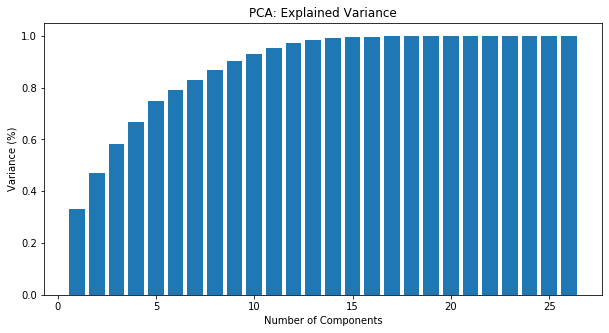

In [163]:
plt.figure(figsize=(10,5))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1, 1), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('PCA: Explained Variance')
plt.show()

In [164]:
pca = PCA(n_components=optimal_number_of_clusters);
features_std_pca = pca.fit_transform(features_std);
features_std_pca = pd.DataFrame(features_std_pca);
features_std_pca.index = features.index
features_std_pca.head()

,0,1,2,3,4,5,6,7,8
address,,,,,,,,,
0x85724d822cc13ffc21fd0f2b0214f672b7beb9ce,-0.309370,1.967256,0.670911,-0.646161,-0.477565,-0.072945,0.000758,-0.030571,0.001164
0xc030c0b80b7982903d87791ac5c57d55e1467b18,-0.166505,0.971991,0.237349,0.007052,-0.481113,-0.060620,0.001210,-0.009594,0.007200
0xc2fe57f293ec95bfe5ef766cc453a2c0f8d9d519,0.838394,3.308583,-0.020964,3.697314,-2.563217,0.524649,0.013293,-0.101216,-0.024850
0xa68eedf559c8158b16311394ab6353ed674407e6,-0.324807,1.948573,0.680696,-0.708289,-0.445777,-0.080049,0.000604,-0.029852,0.001432
0x5b54016c9fd373cd88dd97348fe27ff8e4ba4c48,-0.289409,1.989387,0.659958,-0.578555,-0.505912,-0.060561,0.001006,-0.032282,0.000537


# Die Anzahl der Cluster bestimmen

**Frage:** Soll ich hier schon die nach PCA transformierten feature values verwenden? Im Folgenden treffe ich die Annahme, dass die nach PCA transformierten feature values verwendet werden sollten.

#### Funktionen

In [165]:
def estimateNumberOfClusters(features, features_std_pca, max_number_of_clusters):
    scores = []
    numberOfCluster = []

    for i in range(2,max_number_of_clusters,1):
        kmeans_tmp = KMeans(n_clusters=i)
        kmeans_tmp.fit(features_std_pca)
        numberOfCluster.append(i)
        scores.append(metrics.calinski_harabasz_score(features, kmeans_tmp.labels_))  
    
    result = pd.DataFrame(np.transpose(np.array([numberOfCluster, scores])).astype(int), columns=["Number of Clusters", "C.H. Score"]);
    optimal_number_of_clusters = numberOfCluster[np.argmax(scores)];
    
    return result, optimal_number_of_clusters;

In [166]:
def plotScores(scores):
    plt.figure()
    plt.bar(scores.iloc[:, 0],scores.iloc[:, 1] )
    plt.xlabel('Number of Clusters')
    plt.ylabel('C.H. Score') #for each component
    plt.title('Calinski Harabasz Score')
    plt.show()

In [167]:
scores = []
numberOfCluster = []

# 3 clusters are not considered to be valid
for i in range(min_number_of_clusters, max_number_of_clusters, 1):
    kmeans_tmp = KMeans(n_clusters=i)
    kmeans_tmp.fit(features_std_pca)
    numberOfCluster.append(i)
    scores.append(metrics.calinski_harabasz_score(features, kmeans_tmp.labels_))  

results = pd.DataFrame(zip(numberOfCluster, scores), columns=["number_of_clusters", "calinski_score"])
optimal_number_of_clusters = results.loc[results["calinski_score"].idxmax()].astype(int)["number_of_clusters"]

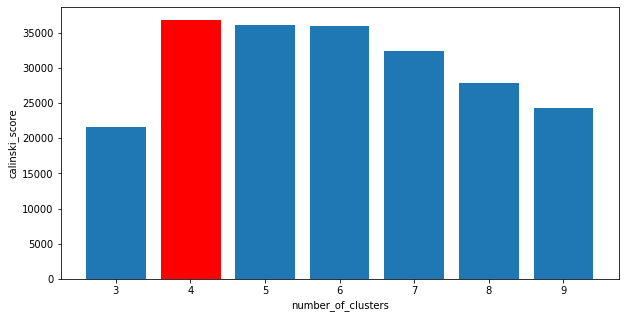

The optimal number of clusters is 4.


In [168]:
plt.figure(figsize=(10,5))
bars = plt.bar(x=results["number_of_clusters"], height=results["calinski_score"])
plt.xlabel(results.columns[0])
plt.ylabel(results.columns[1]) 
bars[results["calinski_score"].idxmax()].set_color("r")
plt.show()
plt.close()
print("The optimal number of clusters is {}.".format(optimal_number_of_clusters))

# Change optimal number manually

In [169]:
#  optimal_number_of_clusters = 5 # tmp

# Ausreißer eliminieren

**Todo**: *Prüfen in wie weit hierdurch wie bei Isolation Forest die exchange features.index rausgehauen werden.*

In [170]:
# def remove_outliers(features, features_std_pca, kmeans, threshold):
    
#     features_std_pca_within_cluster_new = pd.DataFrame();
#     features_within_cluster_new = pd.DataFrame();
#     labels_new = [];

#     for clusterNumber, centroid in enumerate(kmeans.cluster_centers_):
        
#         features_std_pca_within_cluster = features_std_pca[kmeans_opt.labels_ == clusterNumber];
#         features_within_cluster = features[kmeans_opt.labels_ == clusterNumber];
            
#         distances = features_std_pca_within_cluster - centroid;
#         distances_norm = np.linalg.norm(distances, axis=1);

#         maxDistance = threshold * np.linalg.norm(features_std_pca_within_cluster.std())
        
#         keep = distances_norm <= maxDistance
        
#         features_std_pca_within_cluster_new = features_std_pca_within_cluster_new.append(features_std_pca_within_cluster[keep])
#         features_within_cluster_new = features_within_cluster_new.append(features_within_cluster[keep])
#         labels_new.extend([clusterNumber for i in features_within_cluster[keep].iterrows()])
        
#     return features_std_pca_within_cluster_new, features_within_cluster_new, labels_new

In [171]:
# kmeans_opt = KMeans(n_clusters=optimal_number_of_clusters)
# kmeans_opt.fit(features_std_pca)

In [172]:
# from sklearn.metrics import calinski_harabaz_score as ch_score

# thresholds = np.linspace(.01,3, 20)

# test = [remove_outliers(features, features_std_pca, kmeans_opt,t) for t in thresholds]

# scores= []

# for (res1, res2, labels) in test:
#     scores.append(metrics.calinski_harabasz_score(res2, labels)) 

In [173]:
# plt.plot(thresholds, scores)
# plt.title('Calinski Harabaz Scores as std threshold changes')

In [174]:
# optimalThreshold = thresholds[np.argmax(scores)]
# print("The threshold leading to the highest Calinski Harabaz Score is", optimalThreshold)

In [175]:
# features, features_std_pca, labels = remove_outliers(features, features_std_pca, kmeans_opt, optimalThreshold)
# features_std_pca = pd.DataFrame(features_std_pca)
# features = pd.DataFrame(features)

# Visualisierung: T-SNE

In [176]:
# from sklearn.manifold import TSNE

# time_start = time.time()

# tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)
# features_std_pca_out_tsne = tsne.fit_transform(features_std_pca_out)
# features_std_pca_out_tsne = pd.DataFrame(features_std_pca_out_tsne, columns=["1_tsne_comp","1_tsne_comp"])
# features_std_pca_out_tsne.head()

# print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

In [177]:
# # Plot Digits t-SNE
# import seaborn as sns

# # Set style of scatterplot
# sns.set_context("notebook", font_scale=1.1)
# sns.set_style("ticks")

# features_std_pca_out_tsne["Label"] = kmeans_opt.labels_
# features_std_pca_out_tsne.columns = ["x", "y", "Label"]

# sns.lmplot(x='x',
#            y='y',
#            data=features_std_pca_out_tsne,
#            fit_reg=False,
#            legend=True,
#            height=9,
#            hue='Label',
#            scatter_kws={"s":200, "alpha":0.3})


# plt.title('t-SNE Results:', weight='bold').set_fontsize('14')
# plt.xlabel('Prin Comp 1', weight='bold').set_fontsize('10')
# plt.ylabel('Prin Comp 2', weight='bold').set_fontsize('10')

# Clustering

In [178]:
kmeans_opt = KMeans(n_clusters=optimal_number_of_clusters)
kmeans_opt.fit(features_std_pca)

features["label"] = kmeans_opt.labels_

# Cluster Data

In [196]:
clusters = dict() 
labels = features["label"].unique()
labels.sort()

for label in labels:
    cluster_name = 'cluster_{}'.format(label)
    
    features_in_cluster = features[features.label == label]
    
    clusters[cluster_name] = dict()
    clusters[cluster_name]["number_of_addresses"] = Counter(features["label"])[label]
    clusters[cluster_name]["feature_means"] = features_in_cluster.drop(columns=["label"]).mean()
    
feature_means = pd.DataFrame(columns = clusters[cluster_name]['feature_means'].keys())

for key in clusters:
    clusters[key]["feature_means"].name = key
    feature_means = feature_means.append(clusters[key]["feature_means"])

# Display cluster data

In [198]:
feature_means_display = feature_means.round()

feature_means_display["eth_received"] = feature_means_display["wei_received"] / 10**18
feature_means_display["eth_sent"] = feature_means_display["wei_sent"] / 10**18
feature_means_display["eth_balance"] = feature_means_display["balance"] / 10**18
feature_means_display["avg_eth_sent"] = feature_means_display["avg_wei_sent"] / 10**18
feature_means_display["avg_eth_received"] = feature_means_display["avg_wei_received"] / 10**18
feature_means_display["monthly_eth_sent"] = feature_means_display["monthly_wei_sent"] / 10**18
feature_means_display["monthly_eth_received"] = feature_means_display["monthly_wei_received"] / 10**18

feature_means_display = feature_means_display.drop(columns=["wei_received"])
feature_means_display = feature_means_display.drop(columns=["wei_sent"])
feature_means_display = feature_means_display.drop(columns=["balance"])
feature_means_display = feature_means_display.drop(columns=["avg_wei_sent"])
feature_means_display = feature_means_display.drop(columns=["avg_wei_received"])
feature_means_display = feature_means_display.drop(columns=["monthly_wei_sent"])
feature_means_display = feature_means_display.drop(columns=["monthly_wei_received"])

feature_means_display["number_of_addresses"] = [clusters[c]["number_of_addresses"] for c in clusters]

cols = list(feature_means_display.columns.values) 
cols.pop(cols.index('number_of_addresses')) 
cols.pop(cols.index('eth_balance')) 
cols.pop(cols.index('eth_sent')) 
cols.pop(cols.index('eth_received')) 
feature_means_display = feature_means_display[["number_of_addresses", "eth_balance", "eth_sent", "eth_received"]+cols] 


if len(feature_means_display.columns) > len(feature_means_display.index):
    print("Number of Addresses: {}".format(number_of_addresses))
    print("Observation-Period: {} to {}".format(observation_period_start, observation_period_end))
    display(feature_means_display.T.astype("int"))
else:
    display(feature_means_display.astype("int"))

Number of Addresses: 40000
Observation-Period: 2019-11-01 00:00:00+00 to 2020-02-01 00:00:00+00


,cluster_0,cluster_1,cluster_2,cluster_3
number_of_addresses,26567,2,13369,62
eth_balance,74,412630,-26,-23699
eth_sent,2891,5408169,1342,648941
eth_received,2965,5820799,1316,625241
number_of_tx_received,453,925147,5,67314
number_of_tx_sent,664,248244,2,234002
avg_time_diff_received_tx,387728,18,5443121,207970
avg_time_diff_sent_tx,338319,34,5275456,385286
mined_blocks,6,0,0,6671
stddev_received_tx,659199,95,4917408,210678


# Deprecated

## Visualisierung PCA 3D Diagramm

In [181]:
features_std_pca_tmp = pd.DataFrame(features_std_pca_tmp)
features_std_pca_tmp.index = features.index 
features_std_pca_tmp["label"] = features["label"]
features_std_pca_tmp.head()

NameError: name 'features_std_pca_tmp' is not defined

In [ ]:
from mpl_toolkits.mplot3d import Axes3D;

fig = plt.figure(figsize=(10, 10));
ax = Axes3D(fig, elev=-150, azim=110);

pca_tmp = PCA(n_components=3)
features_std_pca_tmp = pca_tmp.fit_transform(features_std);
features_std_pca_tmp = pd.DataFrame(features_std_pca_tmp)
features_std_pca_tmp.index = features.index 
features_std_pca_tmp.columns = ["1st eigenvector", "2st eigenvector", "3st eigenvector"] 
features_std_pca_tmp["label"] = features["label"]
# cmap = plt.cm.Set1
labels = np.sort(features_std_pca_tmp.label.unique())

for l in labels:
    print(l)
    ax.scatter(features_std_pca_tmp["1st eigenvector"][features_std_pca_tmp["label"] == l], 
           features_std_pca_tmp["2st eigenvector"][features_std_pca_tmp["label"] == l],
           features_std_pca_tmp["3st eigenvector"][features_std_pca_tmp["label"] == l],
           label = l, 
           edgecolor='k', s=40, 
               alpha = 1
              );

ax.set_title("PCA Components");
ax.set_xlabel("1st eigenvector");
ax.w_xaxis.set_ticklabels([]);
ax.set_ylabel("2nd eigenvector");
ax.w_yaxis.set_ticklabels([]);
ax.set_zlabel("3rd eigenvector");
ax.w_zaxis.set_ticklabels([]);
ax.legend(title= "Cluster-IDs")

In [ ]:
# fig, ax = plt.subplots(figsize= (20,10))

# scaler = StandardScaler(copy=True, with_mean=True, with_std=True);
# features_std = scaler.fit_transform(features);
# features_std = pd.DataFrame(features_std, columns=features.columns);
# X_reduced = PCA(n_components=2).fit_transform(features_std);

# ax.scatter(X_reduced[:, 0], X_reduced[:, 1], c=kmeans_opt.labels_)
# ax.set_xlabel("Principal Component 1")
# ax.set_ylabel("Principal Component 2")
# pd.Series(kmeans_opt.labels_).unique()

In [ ]:
snowflakes = pd.DataFrame(X_reduced, columns=["PC1", "PC2"]).idxmax()
snowflakes
for i in snowflakes:
    print(features.index[i])

# Vergleich der Ballungen

In [ ]:
from collections import Counter
cluster_sizes = Counter(kmeans_opt.labels_)

cluster_data = {}

for cluster_label, cluster_size in cluster_sizes.most_common():
    features_in_cluster = features[kmeans_opt.labels_==cluster_label]
    cluster_data[cluster_label] = pd.Series([cluster_size], index=["cluster_size"])
    cluster_data[cluster_label] = cluster_data[cluster_label].append(features_in_cluster.mean())
    
cluster_data = pd.DataFrame(cluster_data).T
# cluster_data["avgTimeDiffBetweenReceivedTransactions"] = [ timedelta(seconds=s) for s in cluster_data["avgTimeDiffBetweenReceivedTransactions"]]
# cluster_data["avgTimeDiffBetweenSentTransactions"] = [ timedelta(seconds=s) for s in cluster_data["avgTimeDiffBetweenSentTransactions"]]
cluster_data["cluster_size"] = cluster_data["cluster_size"].astype("int")

# Vergleich der Ballungen durch Visualisierung

In [ ]:
cluster_data_for_plot1 = cluster_data.drop(columns=["cluster_size"])
cluster_data_for_plot1 = cluster_data_for_plot1 / cluster_data_for_plot1.sum()
cluster_data_for_plot1["cluster_size"] = cluster_data["cluster_size"]
# cluster_data_for_plot1 = cluster_data_for_plot1.reset_index()

ax = cluster_data_for_plot1.plot.barh(x="cluster_size" ,figsize=(15,15))

ax.tick_params(
    which="major",
    axis='x', 
    bottom=False
    )

ax.tick_params(
    which="major",
    axis='y', 
    labelsize=15
    ) 

ylabels = ax.get_yticklabels()

ax.legend(loc="lower right", fontsize="larger")

ax.set_xticklabels([])
ylabel = ax.set_ylabel("Size of\nCluster", fontsize="xx-large", rotation=0, labelpad=60)

In [ ]:
cluster_data_for_plot1

In [ ]:
from math import pi

cluster_data_for_plot2 = cluster_data_for_plot1.copy()
cluster_data_for_plot2 = cluster_data_for_plot2.drop(columns=["cluster_size"])
cluster_data_for_plot2 = cluster_data_for_plot2.sort_index()
# cluster_data_for_plot2 = cluster_data_for_plot2.set_index("index")

categories=list(cluster_data_for_plot2)
N = len(categories)

values = {}

for i,v in cluster_data_for_plot2.iterrows(): 
    tmp_values = cluster_data_for_plot2.loc[i].values.tolist()
    tmp_values += tmp_values[:1]
    values[i] = tmp_values

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
angles
 
plt.figure(figsize=(30,40))

for cluster_label, cluster_values in values.items():
    position = int("".join([str(33), str(cluster_label + 1)]))
    axis = plt.subplot(position, polar=True)
    plt.sca(axis)
    plt.xticks(angles[:-1], categories, size=15)

#     plt.ylim(top=1)

    axis.plot(angles, cluster_values, linewidth=1, linestyle='solid')
    axis.fill(angles, cluster_values, 'b', alpha=0.1)
#     a.text(0.1,0.1, cluster_size[i], color = "red", size=20)
    axis.set_title("Cluster with ID={} has {} addresses".format(cluster_label, cluster_sizes[cluster_label]), color = "black", size=25, loc="center", pad=30)
    axis.set_yticks([t for i,t in enumerate(axis.get_yticks()) if i%2!=0])

In [ ]:
yticks = axis.get_yticks()
print(yticks)
newyticks = [t for i,t in enumerate(yticks) if i%2==0]
newyticks
# axis.set_yticks()

In [ ]:
for i,cd in cluster_data.iterrows():
    x = features.index[kmeans_opt.labels_==i]
    print("Length of cluster with id={}: {}".format(i, len(x)))
    display(x)
    print("############################")

# Helper functions to analyse data

In [ ]:
def open_etherscan(cluster_id, number_of_addresses):
    if len(features.index[kmeans_opt.labels_==cluster_id]) > number_of_addresses:
        for a in np.random.choice(features.index[kmeans_opt.labels_==cluster_id], number_of_addresses):
            webbrowser.open('https://etherscan.io/address/{}'.format(a), new=2)
    else:
        for a in features.index[kmeans_opt.labels_==cluster_id]:
            webbrowser.open('https://etherscan.io/address/{}'.format(a), new=2)
    
open_etherscan(8, 3)

In [ ]:
cluster_data

# Recall, Precision und F1 score für das Clustering

In [ ]:
# exchanges = [(a, "e") for i, a in enumerate(features.index) if a.startswith("exchange")]
# speculators = [(a, "x") for i, a in enumerate(features.index) if a.startswith("speculator")]

# exchanges = pd.DataFrame(zip(*exchanges)).T
# speculators = pd.DataFrame(zip(*speculators)).T

# exchanges.columns = ["address", "should_actual_be_in_cluster"]
# speculators.columns = ["address", "should_actual_be_in_cluster"]

# exchanges = exchanges.set_index("address")
# speculators = speculators.set_index("address")

# # features.index[kmeans_opt.labels_ == 2]

# tmp = pd.DataFrame(zip(features.index, kmeans_opt.labels_), columns=["address", "is_in_cluster"])
# tmp = tmp.set_index("address")

# tmp1 = exchanges.append(speculators)

# tmp1 = tmp1.join(tmp, on="address", how="inner")

# cluster_list = []
# for i in tmp1["is_in_cluster"].unique():
#     cluster_list.append(list(tmp1[tmp1["is_in_cluster"] == i]["should_actual_be_in_cluster"]))



In [ ]:
# import collections as collections
# from math import factorial as fac

# def b(x, y):
#     try:
#         binom = fac(x) // fac(y) // fac(x - y)
#     except ValueError:
#         binom = 0
#     return binom

# Counter = collections.Counter

# num_doc= 0
# TP = 0
# FP = 0
# FN = 0
# TN = 0
# c_list = []
# for c in range(0, len(cluster_list)): 
#     # calculating num_doc count...
#     num_doc += len(cluster_list[c])

#     c = Counter(cluster_list[c])
#     c_list.append(c)
#     TP += b(c["e"], 2) 
    
# # Calculate False Positives
    
# for c in range(0, len(cluster_list)): 
#     c = Counter(cluster_list[c])
#     FP += c["e"] * c["x"]

# # Add all the cluster together
# sum = Counter()
# for c in c_list:
#     sum += c

# # calculating FN...
# for ct in c_list:
#     fn_temp = 0 

#     fn_temp += ct["e"]*(sum["e"]-ct["e"])
#     sum -= ct
#     FN += fn_temp


# print("num_doc is %d " % num_doc)
# print("TP is %d " % TP)
# print("FP is %d " % FP)
# print("FN is %d " % FN)
# print("TN is %d " % TN)

# Precision = TP/(TP+FP)
# print("Precision is %.2f " % Precision)

# Recall = TP/(TP+FN)
# print("Recall is %.2f " % Recall)

# F1=(2*Recall*Precision)/(Recall+Precision)
# print("F1 is %.2f " % F1)



In [ ]:
# fig, ax = plt.subplots(figsize= (20,10))

# cluster_list.sort(key=len, reverse = True)
# ind = range(0, len(cluster_list))

# numberOfExchanges = [Counter(cl)["e"] for cl in cluster_list]
# numberOfSpeculators = [Counter(cl)["x"] for cl in cluster_list]

# line1 = ax.barh(ind, numberOfExchanges)
# line2 = ax.barh(ind, numberOfSpeculators, left=numberOfExchanges)

# yticklabels = ax.get_yticklabels()

# start, end = ax.get_ylim()
# ax.set_ylim(-1,7)

# ax.yaxis.set_ticks(np.arange(0, 7, 1))

# ax.legend((line1, line2), ('Exchanges', 'Unkown'), loc="upper right", fontsize="larger")

# yticklabels = ax.set_yticklabels(ind)

# ax.tick_params(
#     which="major",
#     axis='both', 
#     labelsize=13
#     ) 
# ylabel = ax.set_ylabel("Cluster-ID", fontsize="xx-large", rotation=0, labelpad=60)
# ylabel = ax.set_xlabel("Number of features.index", fontsize="xx-large", rotation=0, labelpad=30)


# Temporary stuff

In [ ]:
# import collections as collections

# Counter = collections.Counter

# cluster_list = [['a','a','a','a','a','b'],['a','b','b','b','b','c'],['a','a','c','c','c']]
# num_doc= 0
# positives = 0
# negatives = 0
# TP = 0
# FP = 0
# FN = 0
# TN = 0
# c_list = []
# for c in range(0, len(cluster_list)): 
#     # calculating num_doc count...
#     num_doc += len(cluster_list[c])

#     # calculating positives...
#     positives +=  (len(cluster_list[c])*(len(cluster_list[c])-1))/2

#     # calculating TP...
#     c = Counter(cluster_list[c])
#     c_list.append(c)
#     tp_temp = 0 
#     for k,v in dict(c).items():
#         if v>1:
#             tp_temp += (v*(v-1))/2
#     TP += tp_temp 

# FP = positives - TP
# negatives = ((num_doc*(num_doc-1))/2) - positives
# # Add all the cluster together
# sum = Counter()

# for c in c_list:
#     sum += c

# # calculating FN...
# for ct in c_list:
#     fn_temp = 0 
#     for k,v in dict(ct).items():
#         fn_temp += v*(sum[k]-v)
#     sum -= ct
#     FN += fn_temp
# TN = negatives -FN
# print("num_doc is %d " % num_doc)
# print("positives is %d " % positives)
# print("TP is %d " % TP)
# print("FP is %d " % FP)
# print("FN is %d " % FN)
# print("TN is %d " % TN)

# Precision = TP/(TP+FP)
# print("Precision is %.2f " % Precision)

# Recall = TP/(TP+FN)
# print("Recall is %.2f " % Recall)

# F1=(2*Recall*Precision)/(Recall+Precision)
# print("F1 is %.2f " % F1)

Problem: Mit dem obigen Algorithmus wird die Güte des Clustering Algorithmus ingesamt bestimmt. Ich will aber nur die Güte des Clustering Modell anhand der Exchange Adressen bestimme.

Lösung?: (#Paare im selben cluster) / (#Paare in unterschiedlichen Clustern)

In [ ]:
# import collections as collections

# Counter = collections.Counter

# cluster_list = [['a','a','a','a','a','b'],['a','b','b','b','b','c'],['a','a','c','c','c']]
# num_doc= 0
# positives = 0
# negatives = 0
# TP = 0
# FP = 0
# FN = 0
# TN = 0
# c_list = []
# for c in range(0, len(cluster_list)): 
#     # calculating num_doc count...
#     num_doc += len(cluster_list[c])

#     # calculating positives...
#     positives +=  (len(cluster_list[c])*(len(cluster_list[c])-1))/2

#     # calculating TP...
#     c = Counter(cluster_list[c])
#     c_list.append(c)
#     tp_temp = 0 
#     for k,v in dict(c).items():
#         if v>1:
#             tp_temp += (v*(v-1))/2
#     TP += tp_temp 

# FP = positives - TP
# negatives = ((num_doc*(num_doc-1))/2) - positives
# # Add all the cluster together
# sum = Counter()

# for c in c_list:
#     sum += c

# # calculating FN...
# for ct in c_list:
#     fn_temp = 0 
#     for k,v in dict(ct).items():
#         fn_temp += v*(sum[k]-v)
#     sum -= ct
#     FN += fn_temp
# TN = negatives -FN
# print("num_doc is %d " % num_doc)
# print("positives is %d " % positives)
# print("TP is %d " % TP)
# print("FP is %d " % FP)
# print("FN is %d " % FN)
# print("TN is %d " % TN)

# Precision = TP/(TP+FP)
# print("Precision is %.2f " % Precision)

# Recall = TP/(TP+FN)
# print("Recall is %.2f " % Recall)

# F1=(2*Recall*Precision)/(Recall+Precision)
# print("F1 is %.2f " % F1)